# Number of parameters v.s. Generalization

## 采用的模型

| Model                                                        | Activation |
| :----------------------------------------------------------- | :-------: |
| model：  `Conv(h//4, (3x3))->Pool(2)->Conv(h//2, (3x3))->Pool(2)->Conv(h, (3x3))->Pool(2)->Conv(h, (3x3))->Conv(10, (1x1))->Pool(4)` |   BN+ReLU   |

> 训练采用的参数：`batch_size=400, optimizer=Adam(lr=1e-3, amsgrad=True), epoch=200 `

In [1]:
import sys
sys.path.insert(0, '..')
import os
import torch
from argparse import Namespace
from torch import optim
from model import cross_entropy_loss, accuracy
from model import cifar_model, hidden_list
from dataset import cifar_train_loader, cifar_validate_loader
from solver import HW1Solver

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 设置参数 --- 你可以令visdom=True, 然后在http://localhost:8097上看训练过程 
root = os.path.join(os.path.expanduser('~'), 'data')

config = {'batch_size': 400, 'epochs': 200, 'resume': '', 'verbosity': 1, 'use_cuda': True,
          'lr': 1e-3, 'save_dir': '../pretrained/1_3_2', 'save_freq': 100, 'save_grad': False,
          'data_dir': root, 'dataset': 'cifar', 'valid': True, 'val_step': 1,
          'visdom': False, 'visdom_iter': True, 'visdom_fit': False}
config = Namespace(**config)

In [ ]:
# 训练阶段  --- 可能需要花费几个小时！, 请耐心等待～
# ---友情提示: 你也可以直接使用提供的已训练好的模型, 那么你就别运行这部分了 ---
train_loader = cifar_train_loader(root, config.batch_size)
val_loader = cifar_validate_loader(root, config.batch_size)
for h in hidden_list:
    model = cifar_model(h)
    optimizer = optim.Adam(model.parameters(), config.lr, amsgrad=True)
    loss = cross_entropy_loss
    metrics = [accuracy]
    solver = HW1Solver(model, optimizer, loss, metrics, train_loader, val_loader, config)
    solver.train()

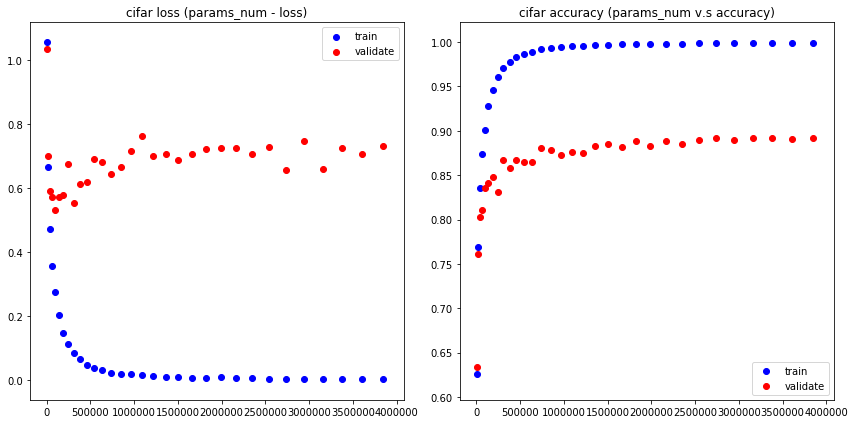

In [4]:
# 可视化
# Warning：如果您采用的是提供的训练好的模型，没事；如果自己训练了，请将下面注释部分修改一下（由于训练好后个人又改动懒得重新跑了）
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.set_title('cifar loss (params_num - loss)')
ax2.set_title('cifar accuracy (params_num v.s accuracy)')
for i, h in enumerate(hidden_list):
    checkpoint = torch.load('{}/cifar_{}_epoch{}.pth.tar'.format(config.save_dir, h, config.epochs))
    logger = checkpoint['logger']
    x = checkpoint['params_num']
    y1 = [entry['loss'] for _, entry in logger.entries.items()][-1]
    y2 = [entry['val_loss'] for _, entry in logger.entries.items()][-1]
    ax1.scatter(x, y1, c='b', label='train' if not i else None)
    ax1.scatter(x, y2, c='r', label='validate' if not i else None)
    y1 = [entry['metrics'] for _, entry in logger.entries.items()][-1]
    y2 = [entry['val_metrics'] for _, entry in logger.entries.items()][-1]
    # 注意: 如果用上述模型训练请将上述两行改为下述两行
    # y1 = [entry['accuracy'] for _, entry in logger.entries.items()][-1]
    # y2 = [entry['val_accuracy'] for _, entry in logger.entries.items()][-1]
    ax2.scatter(x, y1, c='b', label='train' if not i else None)
    ax2.scatter(x, y2, c='r', label='validate' if not i else None)
ax1.legend(loc='best')
ax2.legend(loc='best')
plt.tight_layout()
plt.show()

### 结果分析

1. 随着参数量的增加，train loss不断下降，但是validate loss其实并没有下降，反而在一个范围内波动（只能说稳定在一定范围，似乎也算不上overfitting）
2. 随着参数量的增加，train accuracy不断上述，最后其实是基本接近100%的，而validate accuracy"卡死在了0.85~0.90"之间。这种现象感觉和ResNet论文里面不一致（其实也正常，ResNet里面分析的是Deep的情况，而此处只是加多了通道的实验情况），不知道算不算是overfitting？
3. 个人感觉从这个实验反而能看出在深度学习里面似乎overfitting发生的可能性没那么高～